### Track creator for f1tenth purposes

This notebook is used to map the center line of a novel racetrack for the f1-tenth competition.
The boundaries are then added. 
The .png image and the configuration file are used. 

In [26]:
from PIL import Image 
from tqdm import tqdm 
import numpy as np 
import potrace as pp 
from matplotlib import pyplot as plt 
%matplotlib inline 

filename = '/home/gnone/pbl_drivers/maps/tondo_centerline.png' 


In [27]:
# image import, the image must be in grayscale
im = Image.open(filename)
im_np = np.asarray(im)
if len(im_np.shape) == 3:
    im_np = np.sum(im_np, axis=2)

picture_size = im_np.shape
#if im_np.shape != (2000,2000):
#    raise ValueError("something wrong with the image, the shape is {}".format(im_np.shape))
im_vec = np.clip(im_np, 0, 1)
im_bmp = pp.Bitmap(im_vec)

path = im_bmp.trace()
curves = path.curves
print("The total number of splines is: " + str(len(curves)))

The total number of splines is: 2


At this point we have the total number of splines that potrace found. 
We have to choose the right one and check it with on of the following plots.

In [28]:
# create tesselation
# here we need to find which curves to use 
centerline = curves[1]
centerline = centerline.tesselate(centerline.adaptive, res=1)

print("Number of points of internal curve: {}".format(len(centerline)))

tot_points = min([len(centerline), len(centerline)])

Number of points of internal curve: 74


In [29]:
# since the tesselation kinda sucks, I increase the number of points here 

def improve_tesselation(points):
    points = np.array(points)
    tot_len = 0
    len_points = len(points)
    for i in range(len_points-1):
        tot_len += np.linalg.norm(points[i+1] - points[i])
    tot_len += np.linalg.norm(points[0] - points[-1])

    max_size = tot_len/800
    new_points = []
    new_points.append((points[0]))
    for i in range(1, len_points):
        while np.linalg.norm(new_points[-1]-points[i]) > max_size:
            new_points.append(new_points[-1] + max_size*(points[i] - new_points[-1])/np.linalg.norm(points[i] - new_points[-1]))
        new_points.append(points[i])

    return new_points    

new_centerline = centerline
#new_centerline = improve_tesselation(centerline)


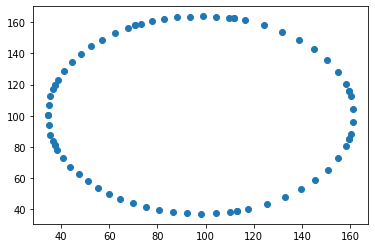

In [30]:
# this next block can be used to asess the quality of tesselation improvement

plt.figure()

plt.plot(np.array(new_centerline)[:, 0], np.array(new_centerline)[:, 1],'o')



In [31]:
picture_size

(200, 200)

In [32]:
# here just some functions

from typing import List

# find points around starting point 

# starting point = 0.8007017, -0.2753365 with pose 4.1421595 (for SOCHI)
# starting point for circle [-75.0, -89]
# these numbers must be converted

start_point = [-9, -25]
start_pose = 3.1415

meters_per_pixel = 0.05
origin_meters= [-11.606540, -26.520793]

def convert_pixel_meter(pixel_coord: List[float] = None, meter_coord: List[float] = None, method: str = 'pm') -> List[float]:
    """
    Utility to convert a pixel coord to float. default converts pixels to meters, can do the opposite too

    Args:
        pixel_coord: tuple containing the coordinate in pixel
        meter_coord: tuple containing the coordinate in meter 
        method: can be either 'pm' for pixel->meters or 'mp'
    """

    if method == 'pm':
        
            out = [ coord * meters_per_pixel for coord in pixel_coord ]
            out = [ a+b for a,b in zip(out, origin_meters) ]
    elif method == 'mp':
        
            out = [ a-b for a,b in zip(meter_coord, origin_meters) ]
            #print(out)
            out = [ coord/meters_per_pixel for coord in out ]
    else:
        raise ValueError('method field can only be pm or mp')
    
    return out


# some tests
#print(convert_pixel_meter(pixel_coord=[1000,1000]))
#print(convert_pixel_meter(meter_coord=[0.8007017, -0.2753365], method='mp'))

def invert_y(point):
    tmp = convert_pixel_meter(meter_coord=point, method='mp')
    return convert_pixel_meter(pixel_coord=[tmp[0], picture_size[0]-tmp[1]])



In [33]:
convert_pixel_meter(pixel_coord=[0, 0], method='pm')

[-11.60654, -26.520793]

In [34]:
convert_pixel_meter(pixel_coord=[200, 200], method='pm')

[-1.6065400000000007, -16.520793]

In [35]:
invert_y([-26.520793, 3.479207])

[-26.520793, -46.520793]

In [36]:
start_point = invert_y(start_point)
print(start_point)


[-9.0, -18.041586000000002]


We need to invert the y-coordinates

In [37]:
new_centerline = [invert_y(a) for a in new_centerline]
new_centerline = [convert_pixel_meter(a) for a in new_centerline]

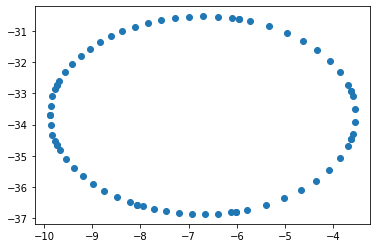

In [38]:
# this next block can be used to asess the quality

plt.figure()

plt.plot(np.array(new_centerline)[:, 0], np.array(new_centerline)[:, 1],'o')

In [39]:
# We need to fit a spline to the line
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

new_centerline = np.array(new_centerline)
new_centerline_clean = np.empty((0,2))

params = np.empty(0)
tot = 0
params = np.concatenate((params, [tot]), axis = None)
new_centerline_clean = np.concatenate((new_centerline_clean, [new_centerline[0]]), axis=0)
i = 0
for (el, prev_el) in (zip(new_centerline[1:, :], new_centerline[:-1, :])):
    tot += np.linalg.norm(el - prev_el)
    if np.linalg.norm(el - prev_el) != 0:
        params = np.concatenate((params, [tot]), axis = None)
        new_centerline_clean = np.concatenate((new_centerline_clean, [el]), axis=0)
        i += 1

if np.linalg.norm(new_centerline[0] - new_centerline[-1]) != 0:
    tot += np.linalg.norm(new_centerline[0] - new_centerline[-1])
    params = np.concatenate((params, [tot]), axis = None)
    new_centerline_clean = np.concatenate((new_centerline_clean, [new_centerline[0]]), axis=0)

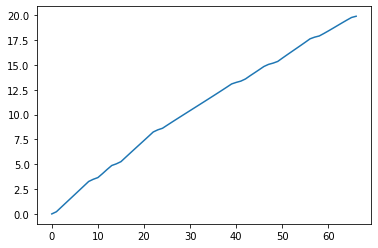

In [40]:
# check monotonicty

plt.plot(params)

In [41]:
# the centerline, parametrized

center_line_x = Spline(params, new_centerline_clean[:, 0], k =3)
center_line_y = Spline(params, new_centerline_clean[:, 1], k =3)

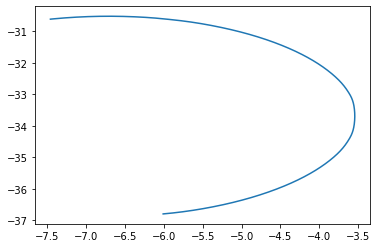

In [42]:
pars = np.linspace(0, 10, 1000)

new_coords_x = [center_line_x(el) for el in pars]
new_coords_y = [center_line_y(el) for el in pars]

plt.plot(new_coords_x, new_coords_y)

In [43]:
print(center_line_x(10, 1))
center_line_y(10, 1)

-0.9707965082808072


array(-0.24143162)

In [44]:
ext_line = np.empty(new_centerline_clean.shape)
int_line = np.empty(new_centerline_clean.shape)
width = 0.31*2

for i, el in enumerate(params):
    direction = np.array((center_line_x(el, 1), center_line_y(el, 1)))
    dir_norm = direction/np.linalg.norm(direction)
    dir_int = np.array((dir_norm[1], -dir_norm[0]))
    dir_ext = np.array((-dir_norm[1], dir_norm[0]))
    int_line[i, :] = new_centerline_clean[i, :] + dir_int*width
    ext_line[i, :] = new_centerline_clean[i, :] + dir_ext*width




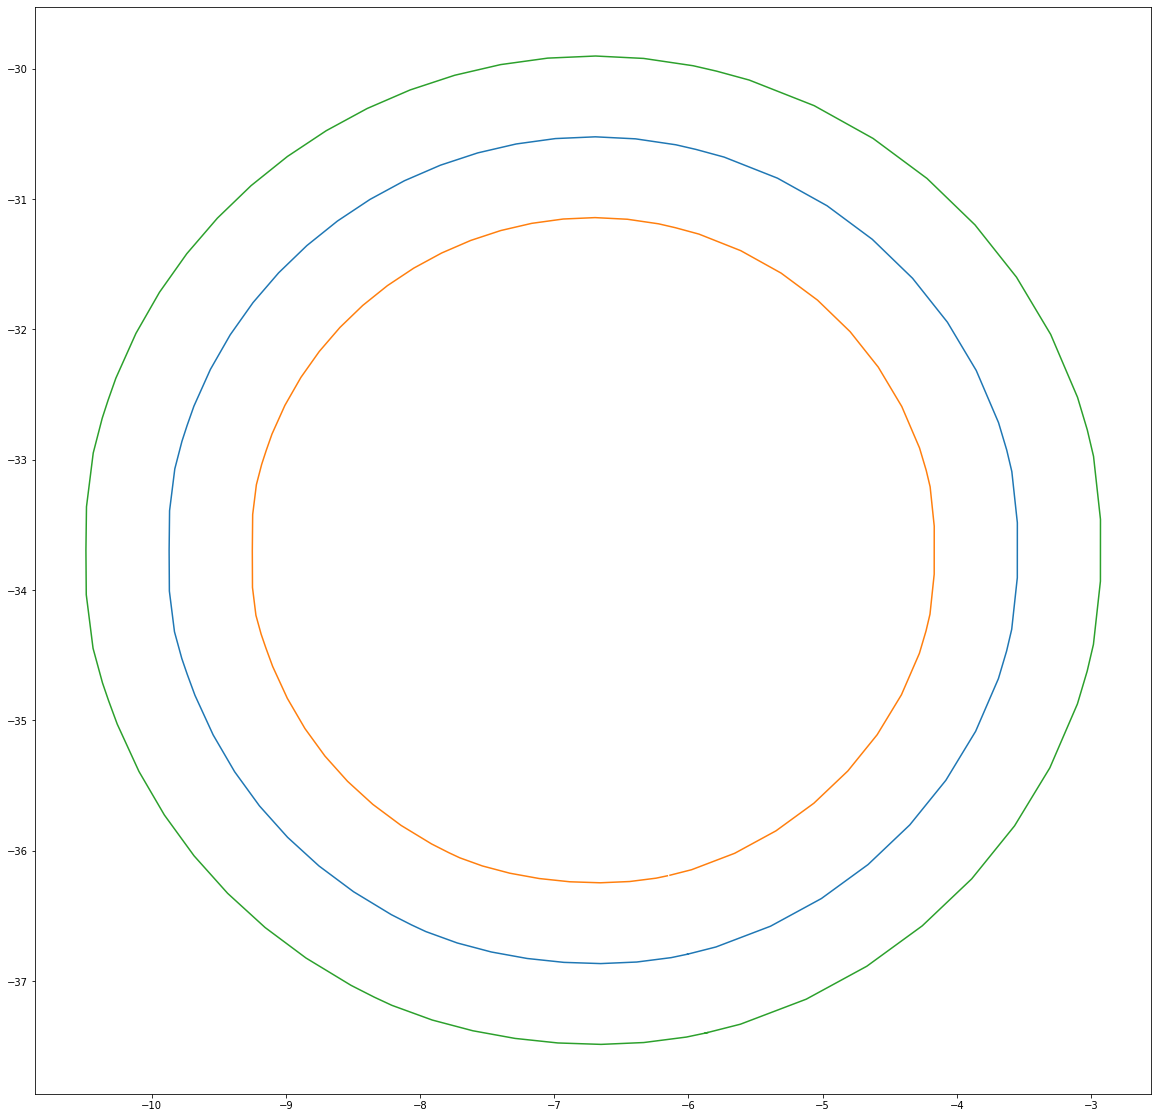

In [45]:
plt.figure(figsize=(20, 20))
plt.plot(new_centerline_clean[:,0], new_centerline_clean[:,1])
plt.plot(ext_line[:,0], ext_line[:,1])
plt.plot(int_line[:,0], int_line[:,1])

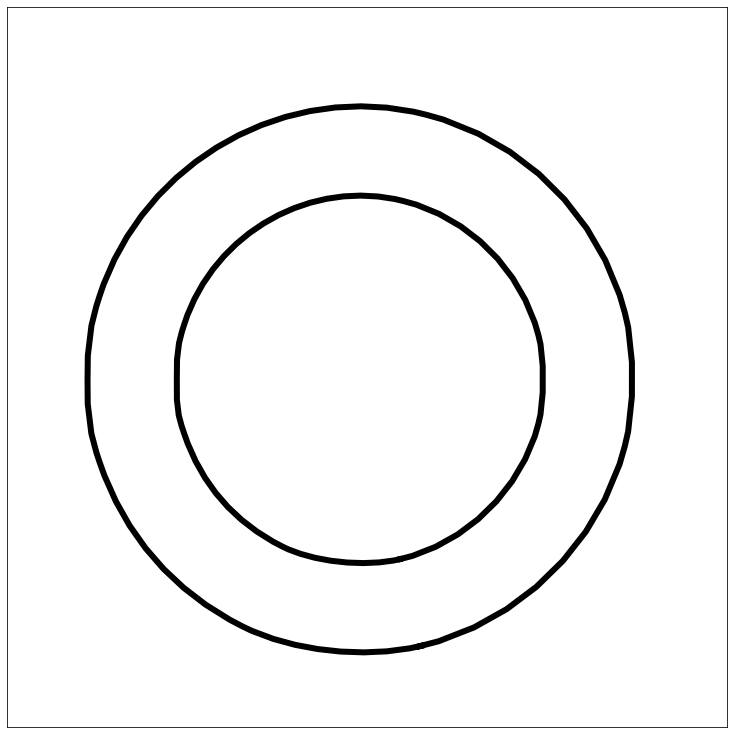

In [50]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(ext_line[:,0], ext_line[:,1], 'k', linewidth=6)
ax.plot(int_line[:,0], int_line[:,1], 'k', linewidth=6)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.set_xlim([-11.60654, -1.60654])
ax.set_ylim([-38.520793, -28.520793])
ax.tick_params(bottom=False,   top=False, left= False, right = False, direction='in')
fig.tight_layout(pad=0)

plt.savefig('tondo.png', bbox_inches='tight', pad_inches=0, dpi=20)

from PIL import Image
Image.open('tondo.png').convert('L').save('tondo.png')

In [60]:
# we can now save these coordinates in a text file 
# CHANGE the name of the text file with the name of the track

with open('tondo_waypoints.txt', 'w') as file:
    file.write("inner_point, midpoint, outer_point, \n")
    for i in range(len(ext_line)):
        file.write("{}, {}, {}, \n".format(list(int_line[i, :]), list(new_centerline_clean[i, :]), list(ext_line[i, :])))
    
with open('tondo_waypoints_new.txt', 'w') as file:
    file.write("length: {}, \n".format(new_centerline_clean.shape[0]))
    file.write("centerline_x, centerline_y, left_w, right_w \n")
    for i in range(len(ext_line)):
        file.write("{}, {}, {}, {}, \n".format(new_centerline_clean[i, 0], new_centerline_clean[i, 1], width, width))

with open('tondo.csv', 'w') as file:
    file.write("# x_m,y_m,w_tr_right_m,w_tr_left_m\n")
    for i in range(len(ext_line)):
        file.write("{},{},{},{}\n".format(new_centerline_clean[i, 0]+9.21289980387475, new_centerline_clean[i, 1]+34.56368663232167, width, width))
